In [2]:
import pandas as pd

file_path_bid = '/Users/gali/Downloads/GRU_predicted_bid_prices.csv'
file_path_ask = '/Users/gali/Downloads/GRU_predicted_ask_prices.csv'

Experiment 4: Moving Average Crossover
This strategy involves using short-term and long-term moving averages. A buy signal is typically generated when the short-term moving average crosses above the long-term moving average, indicating a potential upward trend. Conversely, a sell signal is triggered when the short-term moving average crosses below.

In [8]:
predictions_bid = pd.read_csv(file_path_bid,index_col = 1)
predictions_bid = predictions_bid.rename_axis('time')
predictions_bid = predictions_bid.drop('Type',axis = 1)

In [9]:
predictions_ask = pd.read_csv(file_path_ask,index_col = 1)
predictions_ask = predictions_ask.rename_axis('time')
predictions_ask = predictions_ask.drop('Type',axis = 1)

In [10]:
merged_df = pd.merge(predictions_bid, predictions_ask, left_index=True, right_index=True, how='inner')

merged_df = merged_df.dropna()
merged_df['price'] = merged_df[['BID Price Predicted', 'ASK Price Predicted']].mean(axis=1)
merged_df

,BID Price Predicted,ASK Price Predicted,price
time,,,
1,135.045210,120.793860,127.919535
2,135.054730,120.803640,127.929185
3,135.061200,120.810310,127.935755
4,134.370150,120.100110,127.235130
5,134.306810,120.035020,127.170915
...,...,...,...
12734,111.592050,96.691480,104.141765
12735,111.489680,96.586280,104.037980
12736,111.427124,96.521996,103.974560


In [16]:
file_path = '/Users/gali/Downloads/filtered_data_mimed0101.csv'
actual = pd.read_csv(file_path, index_col = 1)
actual_ask = actual[actual['Type'] == 'ask']
actual_ask = actual_ask['Price'].to_frame()
actual_bid = actual[actual['Type'] == 'bid']
actual_bid = actual_bid['Price'].to_frame()
#actual = actual['Price']

In [18]:
actual = pd.merge(actual_ask, actual_bid, left_index=True, right_index=True, how='inner')

actual = actual.dropna()
actual['price'] = actual[['Price_x', 'Price_y']].mean(axis=1)
actual

,Price_x,Price_y,price
adjusted_time_ints,,,
0.0,258.684211,269.0,263.842105
1.0,254.000000,267.0,260.500000
2.0,258.000000,269.0,263.500000
3.0,259.000000,269.0,264.000000
4.0,261.000000,270.0,265.500000
...,...,...,...
63745.0,107.444444,112.0,109.722222
63746.0,107.727273,112.0,109.863636
63747.0,105.700000,113.0,109.350000


In [19]:
sim = merged_df['price']
act = actual['price']
predictions_df = pd.merge(sim, act, left_index=True, right_index=True, how='inner')
predictions_df = predictions_df.dropna()
predictions_df = predictions_df.rename(columns={'price_x': 'Pred_price'})
predictions_df = predictions_df.rename(columns={'price_y': 'price'})
predictions_df

,Pred_price,price
1.0,127.919535,260.500000
2.0,127.929185,263.500000
3.0,127.935755,264.000000
4.0,127.235130,265.500000
5.0,127.170915,261.000000
...,...,...
12734.0,104.141765,283.500000
12735.0,104.037980,284.000000
12736.0,103.974560,273.718750
12737.0,104.258930,283.083333


In [20]:


# Calculate moving averages
predictions_df['short_ma'] = predictions_df['Pred_price'].rolling(window=5).mean()  # 5-period moving average
predictions_df['long_ma'] = predictions_df['Pred_price'].rolling(window=20).mean()  # 20-period moving average

# Generate signals
predictions_df['Signal'] = 0
predictions_df.loc[predictions_df['short_ma'] > predictions_df['long_ma'], 'Signal'] = 1
predictions_df.loc[predictions_df['short_ma'] < predictions_df['long_ma'], 'Signal'] = -1
print(predictions_df['Signal'])

1.0        0
2.0        0
3.0        0
4.0        0
5.0        0
          ..
12734.0   -1
12735.0   -1
12736.0   -1
12737.0    1
12738.0    1
Name: Signal, Length: 12738, dtype: int64


In [28]:
def simulate_trading(df, initial_capital):
    cash = initial_capital
    holdings = 0
    portfolio_values = []

    # Assume the price to use for trading is the predicted price
    for index, row in df.iterrows():
        if row['Signal'] == 1 and cash > 0:  # Buy
            holdings = cash / row['price']  # Buy as much as possible
            cash = 0
        elif row['Signal'] == -1 and holdings > 0:  # Sell
            cash = holdings * row['price']
            holdings = 0
        
        # Update portfolio value for each step
        portfolio_value = cash + holdings * row['price']
        portfolio_values.append(portfolio_value)

    df['Portfolio_Value'] = portfolio_values
    return df

# Starting capital for the simulation
initial_capital = 10000  # Adjust as necessary

# Run the trading simulation
predictions_df = simulate_trading(predictions_df, initial_capital)


In [29]:
def calculate_profit(df, initial_capital):
    final_portfolio_value = df['Portfolio_Value'].iloc[-1]
    profit = final_portfolio_value - initial_capital
    return profit

# Calculate the profit
profit = calculate_profit(predictions_df, initial_capital)
print(f"Initial Capital: ${initial_capital}")
print(f"Final Portfolio Value: ${predictions_df['Portfolio_Value'].iloc[-1]:.2f}")
print(f"Profit or Loss: ${profit:.2f}")


Initial Capital: $10000
Final Portfolio Value: $9097.18
Profit or Loss: $-902.82


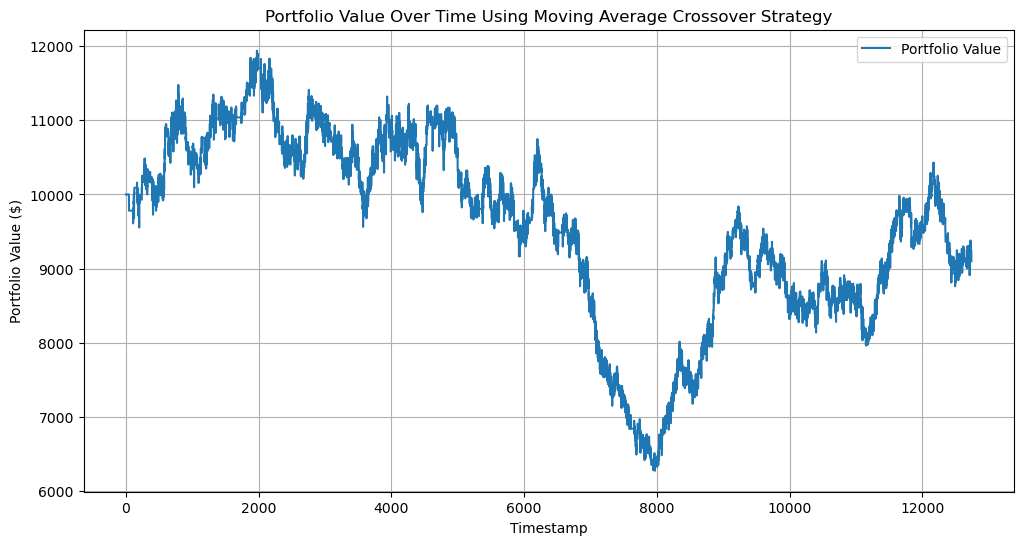

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(predictions_df['Portfolio_Value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time Using Moving Average Crossover Strategy')
plt.xlabel('Timestamp')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()
